In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
np.set_printoptions(linewidth=100)

In [3]:
# %load_ext autoreload
# %autoreload 2

In [4]:
np.set_printoptions(linewidth=120)
plt.rcParams["figure.figsize"] = (18,10)
plt.rcParams["legend.loc"] = "lower right"

import os
base_dir = '/local/scratch/toolkit/'
os.environ['EXOT_ACCESS_DIR'] = str(base_dir + "benchmark_platforms_access/")
os.chdir(base_dir + 'datapro')
print("Working directory: " + str(os.getcwd()))
print("Key directory set to: " + str(os.environ['EXOT_ACCESS_DIR']))

Working directory: /local/scratch/toolkit/datapro
Key directory set to: /local/scratch/toolkit/benchmark_platforms_access/


In [5]:
import toml
import pandas
import seaborn
import re
from pathlib import Path
from pprint import pprint

import exot
import exot.experiment
import exot.util
import exot.layer
from exot.util       import *
from exot.layer      import *
from exot.channel    import *
from exot.experiment import *

Tensorflow not available - excluding packets using it!


### Setup

In [6]:
PLATFORM_X86 = "Haswell"   
PLATFORM_AARCH64 = "ARMv8"

RUN=True
PLOT=True
RESTORE=True

In [7]:
COUNT=250_000
SETS=64

In [8]:
config =\
{'name': 'cache-cc_capacity',
 'save_path': './data',
 'backup_path': './data/_backup',
 'experiment_exists_action': 'update',
 'EXPERIMENT': {'type': 'ExploratoryExperiment',
  'channel': 'CacheCC',
  'PHASES': {},
  'LAYERS': {'io': {'name': 'TimeValue',
    'params': {'synchronise': False, 'timebase': 'ns'}}},
  'GENERAL': {'latency': 10,
   'fan': True,
   'governors': 'userspace',
   'frequencies': 'max',
   'timeout_duration': 500000,
   'sampling_period': 0.001,
   'active_wait': True}},
 'ENVIRONMENTS': {
  PLATFORM_X86: {'APPS': {'src': {'executable': 'utility_cache_hist',
     'zone': 'host'}},
   'src': {'utility': {'host_policy': 'round_robin',
     'host_priority': 99,
     'host_pinning': 0,
     'count': COUNT,
     'sets': SETS},
    'logging': {'log_level': 'debug',
     'provide_platform_identification': True,
     'async': True}}},
  PLATFORM_AARCH64: {'APPS': {'src': {'executable': 'utility_cache_hist',
     'zone': 'combined'}},
   'src': {'utility': {'host_policy': 'round_robin',
     'host_priority': 99,
     'host_pinning': 0,
     'count': COUNT,
     'sets': SETS,
     'measure_with_perf': True},
    'logging': {'log_level': 'debug',
     'provide_platform_identification': True,
     'async': True}}}}}

config["EXPERIMENT"]["PHASES"]["run"] = {}
config["EXPERIMENT"]["PHASES"]["run"]["repetitions"] = 1
config["EXPERIMENT"]["PHASES"]["run"]["rdpstreams"] = [
    pandas.DataFrame({"timestamp": np.arange(0, 5), "value": np.arange(0, 5)})
]

In [9]:
if not RUN:
    raise RuntimeError("")

# Run on x86

In [10]:
channel    = ChannelFactory()(config["EXPERIMENT"]["channel"])
experiment = ExperimentFactory()(config["EXPERIMENT"]["type"], config=config, channel=channel)
experiment.generate()
experiment.write()

2020-05-02 11:27:23 :: bootstrapped layer 'io' with TimeValue


In [11]:
experiment.execute_in_environment(PLATFORM_X86, ['run'], resume=False)

2020-05-02 12:20:10 :: executing phases: ['run'] in env 'Haswell'
2020-05-02 12:20:13 :: Haswell->host: connected: SSHUnixDriver
2020-05-02 12:20:13 :: Haswell->host: sending experiment
2020-05-02 12:20:13 :: Haswell->host: experiment sent!
2020-05-02 12:20:13 :: Haswell->host: configuring to {'latency': 10, 'fan': True, 'governors': 'userspace', 'frequencies': 'max', 'timeout_duration': 500000, 'sampling_period': 0.001, 'active_wait': True, 'STANDARD': {'latency': 10, 'fan': True, 'governors': 'userspace', 'frequencies': 'max', 'timeout_duration': 500000, 'sampling_period': 0.001, 'active_wait': True}}
2020-05-02 12:20:21 :: executing in env: 'Haswell', resume: False, reps: [0], run: <Run at 0x7fa16fdae048 (digested, config={'phase': 'run', 'rdpstream_id': 0, 'repetitions': 1})>
2020-05-02 12:20:21 :: executing in env: Haswell, rep: 0, estimated duration: 10s, run: <Run at 0x7fa16fdae048 (digested, config={'phase': 'run', 'rdpstream_id': 0, 'repetitions': 1})>
2020-05-02 14:03:07 :: H

In [12]:
run = experiment.phases['run'][0]
run.parent.layers.io.get_available_environments()

['ARMv8', 'Haswell']

In [13]:
try:
    experiment.drivers[PLATFORM_X86]["host"].connect()
    tsc_freq_line = experiment.drivers[PLATFORM_X86]["host"].command("dmesg | grep 'Refined TSC'").stdout
    tsc_freq = float(re.findall(r"[-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?", tsc_freq_line)[1][0]) * 1e6
    experiment.drivers[PLATFORM_X86]["host"].disconnect()
except:
    tsc_freq = 2394458000.0

print("TSC freq:", tsc_freq)

TSC freq: 2394444000.0


In [14]:
measurements_x86 = run.parent.layers.io.get_logs(env=PLATFORM_X86, app="src", rep=0)
run.add_intermediate("measurements_x86", measurements_x86)

measurements_x86['duration'] = measurements_x86['duration'].div(tsc_freq / 1e9)

In [15]:
save_path = experiment.path.joinpath("measurements_x86.pickle")

In [16]:
measurements_x86.to_pickle(save_path)

# Run on ARM

In [10]:
experiment = ExploratoryExperiment.read(Path("./data/cache-cc_capacity/_experiment.pickle"))

experiment.config["EXPERIMENT"]["PHASES"]["run"] = {}
experiment.config["EXPERIMENT"]["PHASES"]["run"]["repetitions"] = 1
experiment.config["EXPERIMENT"]["PHASES"]["run"]["rdpstreams"] = [
    pandas.DataFrame({"timestamp": np.arange(0, 5), "value": np.arange(0, 5)})
]

2020-05-02 12:20:12 :: unpicked an experiment instance <ExploratoryExperiment at 0x7f7b877d2208 with CacheCC channel, configured>


In [11]:
experiment.execute_in_environment(PLATFORM_AARCH64, ['run'], resume=False)

2020-05-02 12:20:12 :: executing phases: ['run'] in env 'ARMv8'
2020-05-02 12:20:15 :: ARMv8->combined: connected: SSHUnixDriver
2020-05-02 12:20:15 :: ARMv8->combined: sending experiment
2020-05-02 12:20:17 :: ARMv8->combined: experiment sent!
2020-05-02 12:20:17 :: ARMv8->combined: configuring to {'latency': 10, 'fan': True, 'governors': 'userspace', 'frequencies': 'max', 'timeout_duration': 500000, 'sampling_period': 0.001, 'active_wait': True, 'STANDARD': {'latency': 10, 'fan': True, 'governors': 'userspace', 'frequencies': 'max', 'timeout_duration': 500000, 'sampling_period': 0.001, 'active_wait': True}}
2020-05-02 12:20:25 :: executing in env: 'ARMv8', resume: False, reps: [0], run: <Run at 0x7f7b87523978 (digested, config={'phase': 'run', 'rdpstream_id': 0, 'repetitions': 1})>
2020-05-02 12:20:25 :: executing in env: ARMv8, rep: 0, estimated duration: 10s, run: <Run at 0x7f7b87523978 (digested, config={'phase': 'run', 'rdpstream_id': 0, 'repetitions': 1})>
2020-05-03 14:03:03 ::

In [12]:
run = experiment.phases['run'][0]
run.parent.layers.io.get_available_environments()

['ARMv8', 'Haswell']

In [13]:
try:
    log_aarch64 = run.parent.layers.io.get_logs(env=PLATFORM_AARCH64, app="src", rep=0, suffix=".debug.txt")
    
    aarch64_freqs = {}
    
    for line in log_aarch64.split("\n"):
        match = re.search(r"cpu: (\d),.+, frequencies: \[(\d+),(\d+)\]", line)
        if match:
            aarch64_freqs[int(match.groups()[0])] = int(match.groups()[2])
    
    aarch64_freq = aarch64_freqs[experiment.config.ENVIRONMENTS[PLATFORM_AARCH64].src.utility.host_pinning]
except:
    aarch64_freq = 2035200000
print("aarch64_freq:", aarch64_freq)

aarch64_freq: 2035200000


In [14]:
measurements_aarch64 = run.parent.layers.io.get_logs(env=PLATFORM_AARCH64, app="src", rep=0)
run.add_intermediate("measurements_aarch64", measurements_aarch64)
measurements_aarch64.head()

div_all = (
    experiment.config.ENVIRONMENTS[PLATFORM_AARCH64].src.utility.measure_with_perf
    if "measure_with_perf" in experiment.config.ENVIRONMENTS[PLATFORM_AARCH64].src.utility
    else True
)

if div_all:
    measurements_aarch64['duration'] /= (aarch64_freq / 1e9)
else:
    measurements_aarch64.loc[measurements_aarch64["category"] == "access"] = \
        measurements_aarch64.loc[measurements_aarch64["category"] == "access"] / (aarch64_freq / 1e9)

In [15]:
measurements_aarch64.to_pickle(experiment.path.joinpath("measurements_aarch64.pickle"))

# Restore

In [10]:
if RESTORE:
    measurements_x86     = pandas.read_pickle("./data/cache-cc_capacity/measurements_x86.pickle")
    measurements_aarch64 = pandas.read_pickle("./data/cache-cc_capacity/measurements_aarch64.pickle")

### Histograms

In [11]:
if not PLOT:
    raise RuntimeError("")
#measurements_aarch64.groupby(["method", "category", "class", "sets"])["duration"].describe()
#measurements_x86.groupby(["method", "category", "class", "sets"])["duration"].describe()
export_data = pandas.DataFrame({'Covert Channel':[], 
                                'env':[], 
                                'cached [ns]':[], 
                                'flushed [ns]':[], 
                                'capacity [kpbs]':[]
                               })

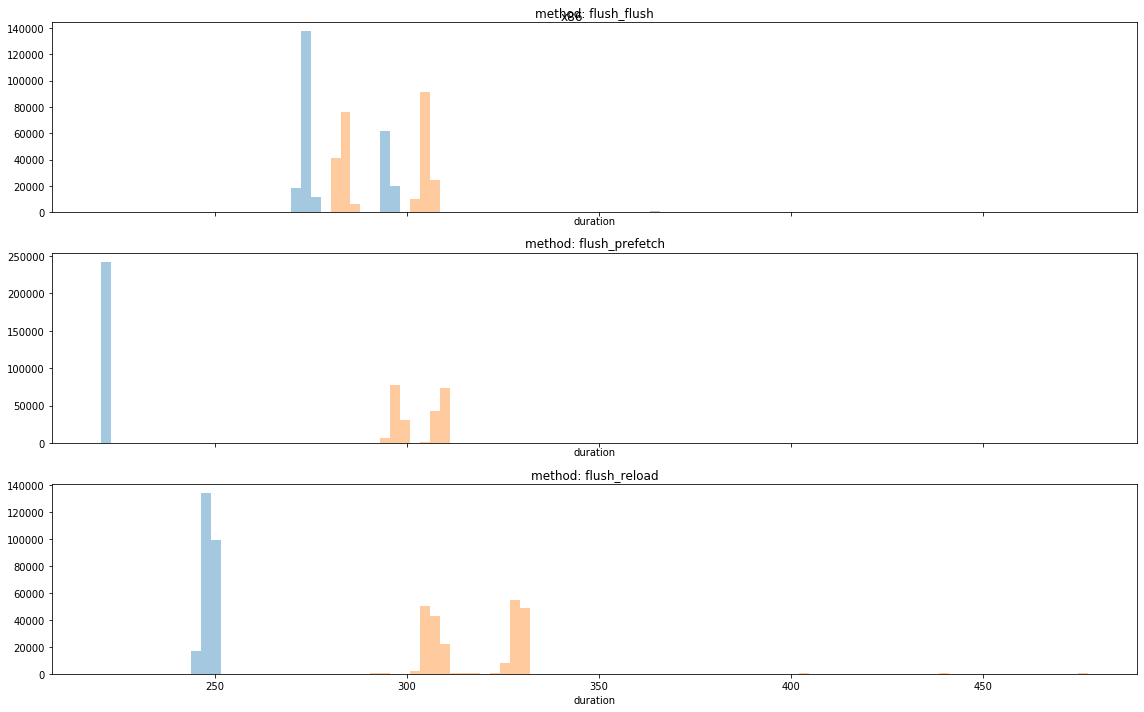

In [12]:
category = "access"
sets = 1

measurements = measurements_x86
methods = ["flush_flush", "flush_prefetch", "flush_reload"] # measurements["method"].unique()
mfilter = (measurements["category"] == category) & (measurements["sets"] == sets)

f, axes = plt.subplots(len(methods), 1, figsize=(16, 10), sharex=True)

limits = np.quantile(measurements.loc[mfilter]["duration"], [0.01, 0.99])
bins = np.linspace(limits[0], limits[1], 100)

for i, method in enumerate(methods):
    hit_data = measurements.loc[mfilter & (measurements["method"] == method) &
                         (measurements["class"] == "hit")]["duration"]
    
    miss_data = measurements.loc[mfilter & (measurements["method"] == method) &
                         (measurements["class"] == "miss")]["duration"]
    
    seaborn.distplot(hit_data, bins=bins, ax=axes[i], kde=False)
    seaborn.distplot(miss_data, bins=bins, ax=axes[i], kde=False)
    axes[i].set_title(f"method: {method}")
    export_data.loc[export_data.shape[0]] = [method, 
                                             'Haswell', 
                                             hit_data.mean(), 
                                             miss_data.mean(),
                                             (1/(np.min([hit_data.mean(), miss_data.mean()]) * 10**-9)/10**3
                                            ]
        
plt.suptitle("x86")
f.tight_layout()
f.savefig("hist-1-x86.pdf")

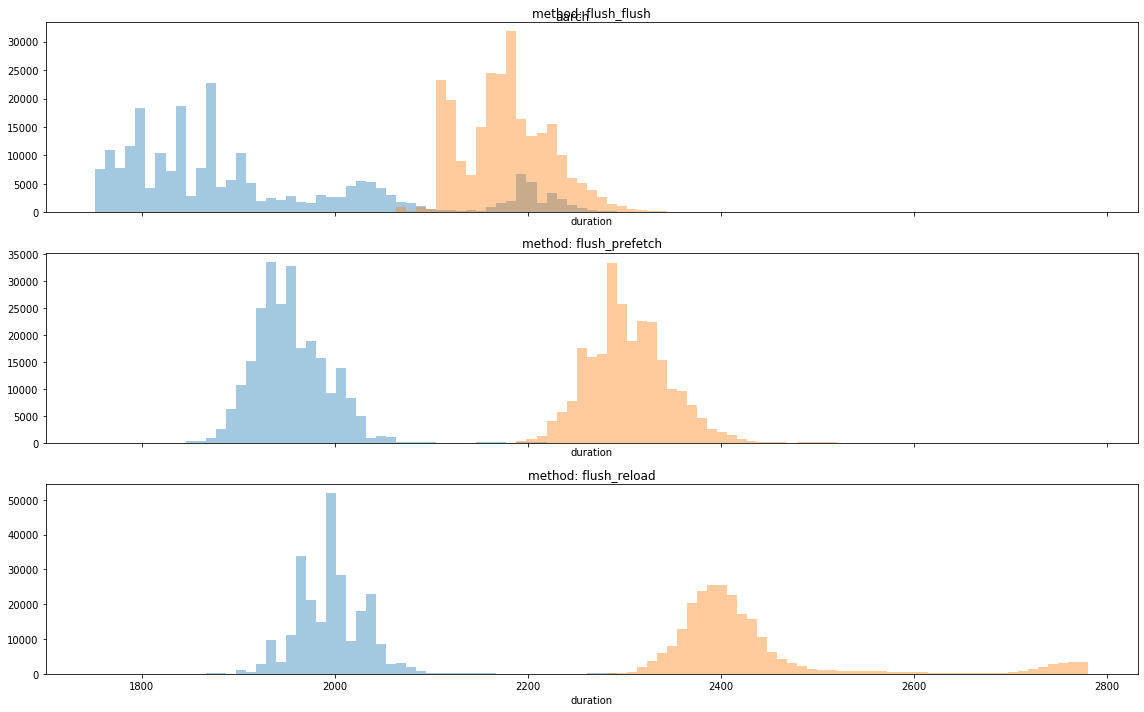

In [13]:
category = "access"
sets = 1

measurements = measurements_aarch64
methods = ["flush_flush", "flush_prefetch", "flush_reload"] # measurements["method"].unique()
mfilter = (measurements["category"] == category) & (measurements["sets"] == sets)

f, axes = plt.subplots(len(methods), 1, figsize=(16, 10), sharex=True)

limits = np.quantile(measurements.loc[mfilter]["duration"], [0.01, 0.99])
bins = np.linspace(limits[0], limits[1], 100)

for i, method in enumerate(methods):
    hit_data = measurements.loc[mfilter & (measurements["method"] == method) &
                         (measurements["class"] == "hit")]["duration"]
    
    miss_data = measurements.loc[mfilter & (measurements["method"] == method) &
                         (measurements["class"] == "miss")]["duration"]
    
    seaborn.distplot(hit_data, bins=bins, ax=axes[i], kde=False)
    seaborn.distplot(miss_data, bins=bins, ax=axes[i], kde=False)
    axes[i].set_title(f"method: {method}")
    export_data.loc[export_data.shape[0]] = [method, 
                                             'ARMv8', 
                                             hit_data.mean(), 
                                             miss_data.mean(),
                                             (1/(np.min([hit_data.mean(), miss_data.mean()]) * 10**-9)/10**3
                                            ]
        
plt.suptitle("aarch")
f.tight_layout()
f.savefig("hist-1-aarch.pdf")

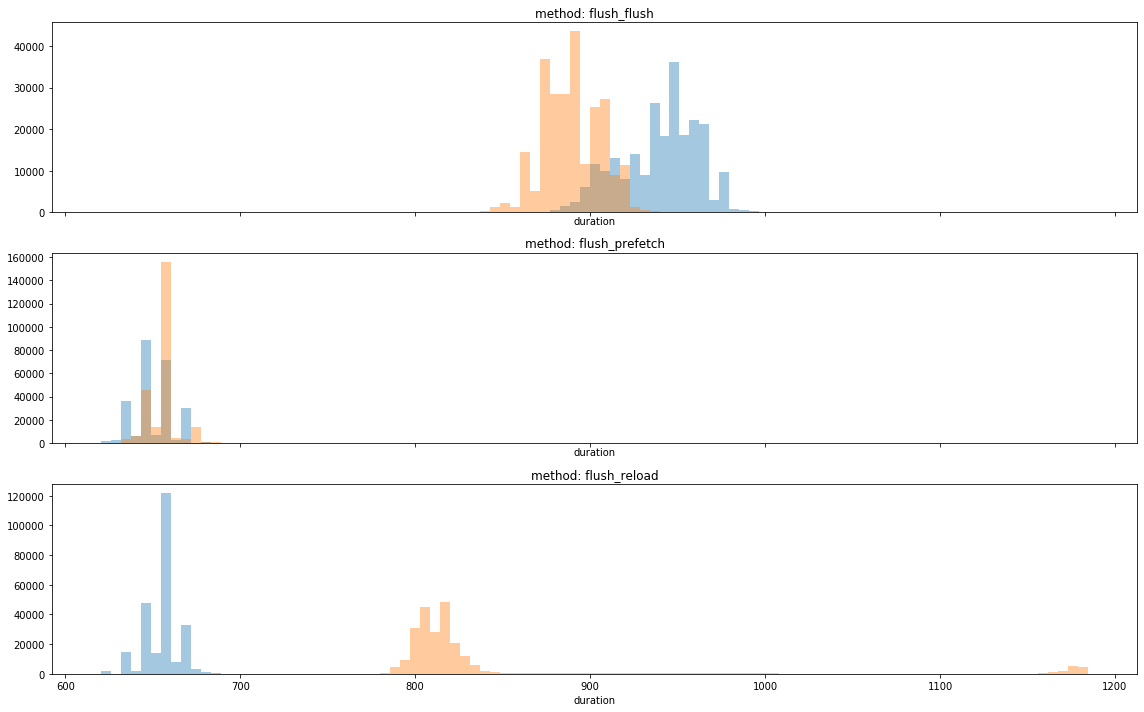

In [14]:
# PLOT RAW

category = "raw"

measurements = measurements_aarch64
methods = ["flush_flush", "flush_prefetch", "flush_reload"] # measurements["method"].unique()

f, axes = plt.subplots(len(methods), 1, figsize=(16, 10), sharex=True)

limits = np.quantile(measurements.loc[(measurements["category"] == category)]["duration"], [0.01, 0.99])
bins = np.linspace(limits[0], limits[1], 100)

for i, method in enumerate(methods):
    hit_data = measurements.loc[(measurements["method"] == method) &
                         (measurements["category"] == category) &
                         (measurements["class"] == "hit")]["duration"]
    
    miss_data = measurements.loc[(measurements["method"] == method) &
                         (measurements["category"] == category) &
                         (measurements["class"] == "miss")]["duration"]
    
    seaborn.distplot(hit_data, bins=bins, ax=axes[i], kde=False)
    seaborn.distplot(miss_data, bins=bins, ax=axes[i], kde=False)
    axes[i].set_title(f"method: {method}")
        
f.tight_layout()

### Boxplots

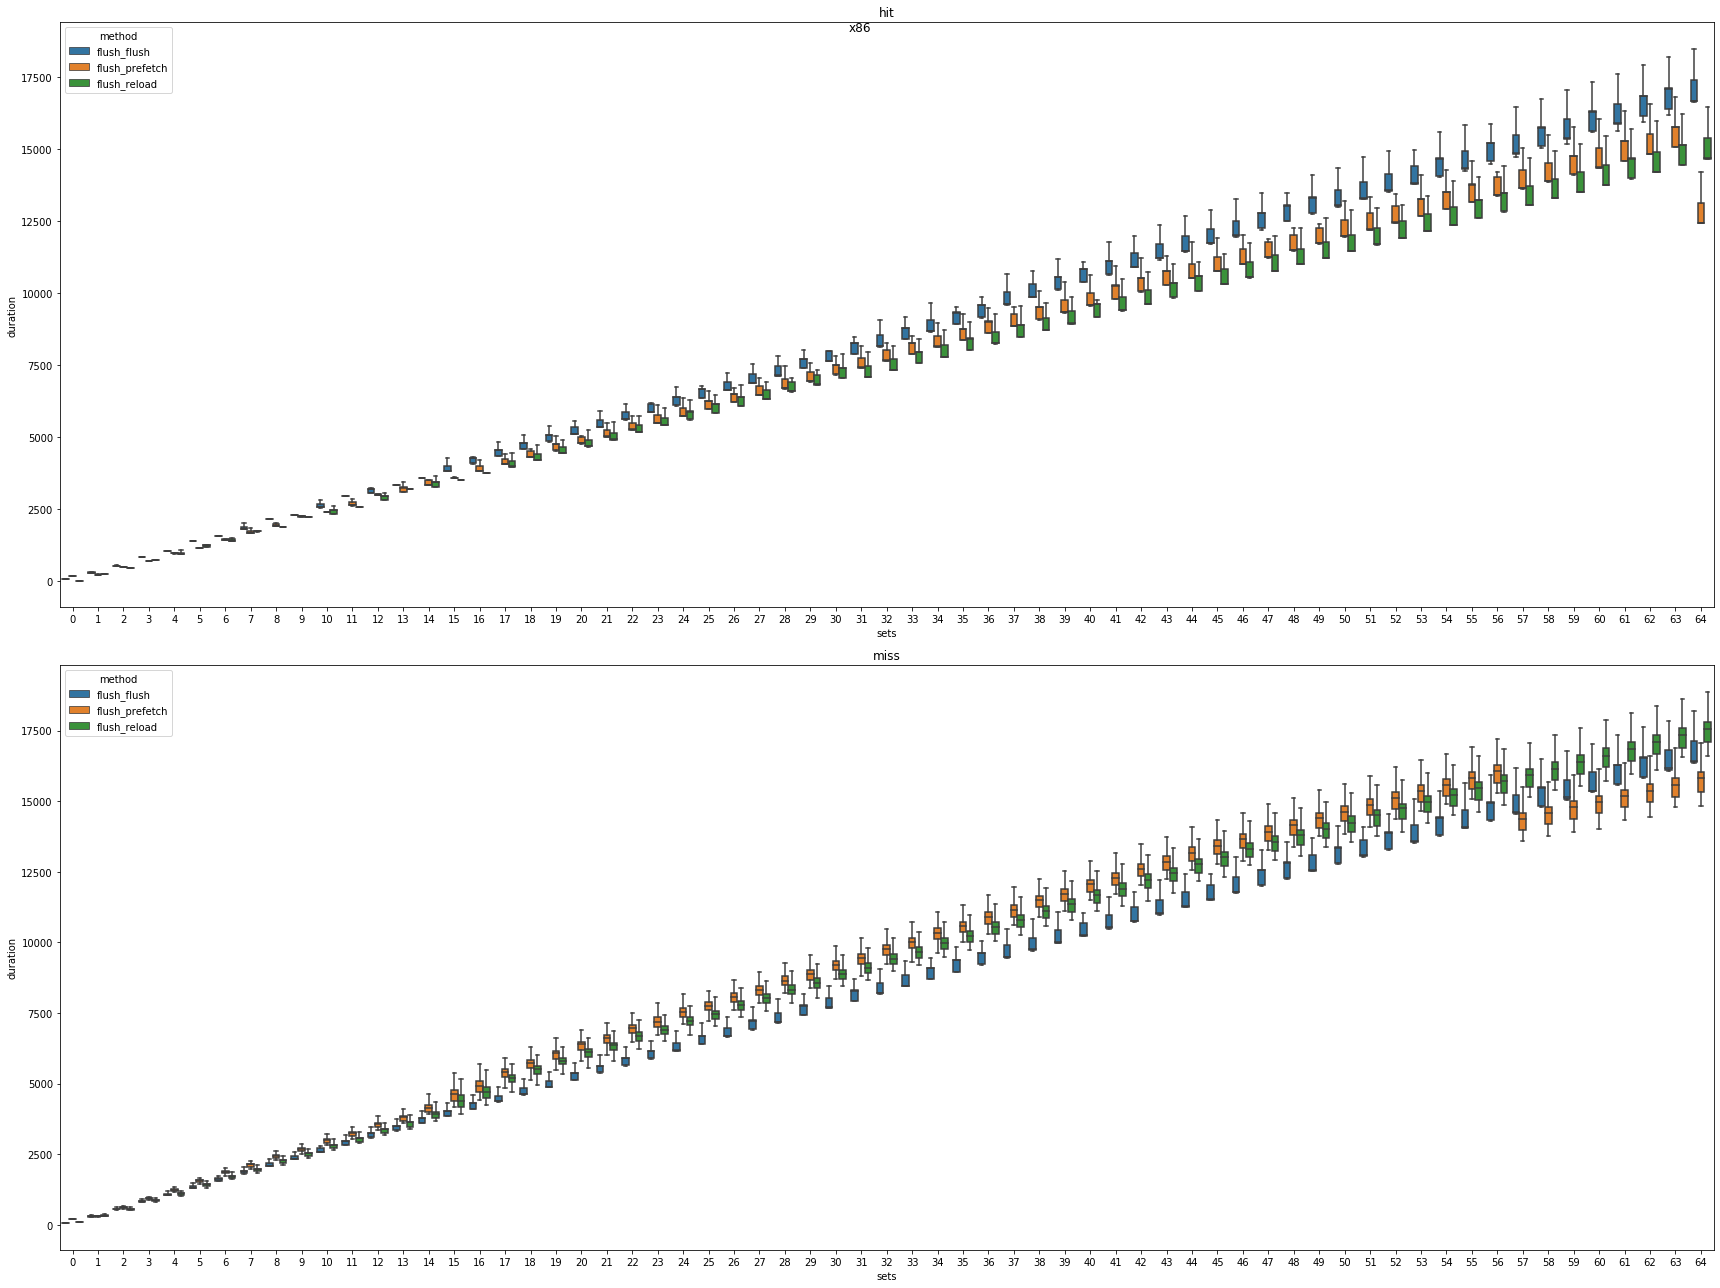

In [15]:
f, axes = plt.subplots(2, 1, figsize=(24, 18))
seaborn.boxplot(x="sets", y="duration", hue="method", showfliers=False,
                data=measurements_x86.loc[measurements_x86["class"] == "hit"], ax=axes[0])
seaborn.boxplot(x="sets", y="duration", hue="method", showfliers=False,
                data=measurements_x86.loc[measurements_x86["class"] == "miss"], ax=axes[1])
axes[0].set_title("hit")
axes[1].set_title("miss")
f.suptitle("x86")
f.tight_layout()
f.savefig("x86-box.pdf")

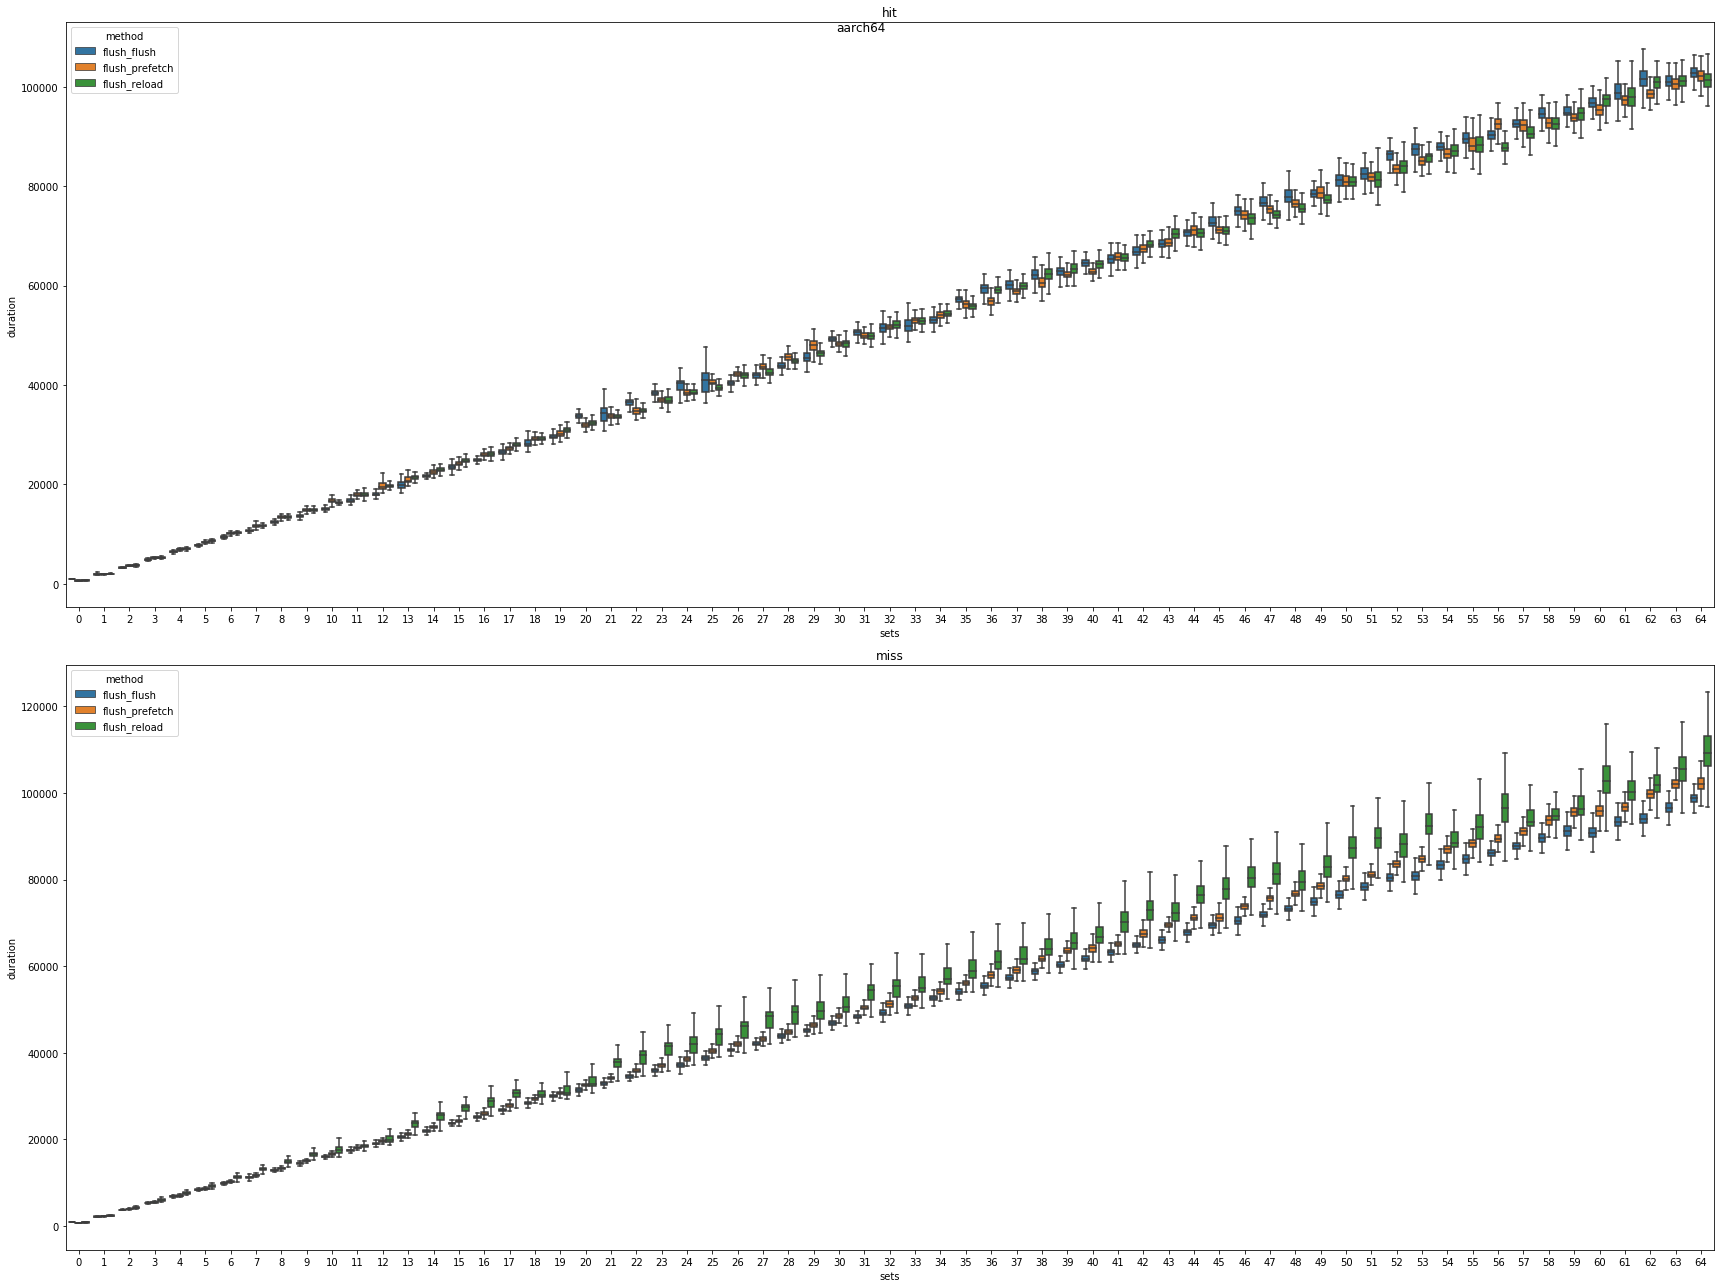

In [16]:
f, axes = plt.subplots(2, 1, figsize=(24, 18))
seaborn.boxplot(x="sets", y="duration", hue="method", showfliers=False,
                data=measurements_aarch64.loc[measurements_aarch64["class"] == "hit"], ax=axes[0])
seaborn.boxplot(x="sets", y="duration", hue="method", showfliers=False,
                data=measurements_aarch64.loc[measurements_aarch64["class"] == "miss"], ax=axes[1])
axes[0].set_title("hit")
axes[1].set_title("miss")
f.suptitle("aarch64")
f.tight_layout()
f.savefig("aarch-box.pdf")

# Export values

In [17]:
export_data

,Covert Channel,env,cached [ns],flushed [ns],capacity [kpbs]
0,flush_flush,Haswell,281.254443,294.566314,3555.499383
1,flush_prefetch,Haswell,221.417761,312.929276,4516.349536
2,flush_reload,Haswell,248.338605,328.478497,4026.760153
3,flush_flush,ARMv8,1910.124318,2183.353406,523.526134
4,flush_prefetch,ARMv8,1960.714955,2310.032101,510.018041
5,flush_reload,ARMv8,2001.394778,2450.717040,499.651549
